**Educational Attainment and Success**


---


Chieh-Huang Chen \
Melvin Cherian \
Michael LI \


---

Course: CSC 59970 - Introduction to Data Science \
Instructor: Grant M. Long
Project



**Goals for this Project**

1.  Apply Python to load, clean, and process data sets.
2.  Identify key patterns in a data set using computational analysis and statistical methods.
3.  Apply principles of statistical modeling and machine learning to data.
4.  Effectively explain, visualize, and communicate empirical findings.


---

**Our Questions**


*   What human development indicators strongly correlate with adult education level in countries?
*   What are significant factors from each major category from the human development dataset that determines adult education level in countries?
*   Which countries have a strong potential in increasing their education level within the next five years?


---


*Libraries*


*   Numpy
*   Pandas
*   Matplotlib
*   Scikit-learn
*   Statsmodels


In [0]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error

*Loading Data into Memory*

---

We loaded Human Development Indicators (HDI) dataset into memory.

We specifically removed column 9999 from our dataset because it only shows the latest value from the data drawn within 1990 to 2017. In this analysis, we analyzed these indicators over time to predict the future of education level in each country.

In [0]:
# Loading Datasets on to DataFrames
indicators_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/2018_all_indicators.csv'

inds_df = pd.read_csv(indicators_url)

inds_df = inds_df.drop(columns=['9999'])

Many of our HDIs only have zero or one recordings in the dataset in years between 1990 to 2017. Due to the lack of data over time, we decided to remove these indicators that has at most 2 data points in each row.

When we removed these indicators, it cleans up at least 28% of the HDI dataset.

In [84]:
threshold = 0
drop_stack = set()
length_before = len(inds_df)
print("Number of rows in the indicators data frame before the cleanup:", length_before)
for index, row in inds_df.iterrows():
    if row['1990':].count() <= threshold:
        drop_stack.add(index)

inds_df = inds_df.drop(drop_stack)
length_after = len(inds_df)
print("Number of rows in the indicators data frame after the cleanup:", length_after)
print("% of rows deleted: {0:.2f}%".format((length_before - length_after) * 100 / length_after))


Number of rows in the indicators data frame before the cleanup: 25636
Number of rows in the indicators data frame after the cleanup: 22918
% of rows deleted: 11.86%


*Plotting Correlations for each country*

We have a method to retrieve each indicators for a country we specify for future uses.

In [0]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    # https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas/31384328#31384328
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
  
def plot_corr_country(df, country):
  # drop ids etc., get only rows with country, transpose
  df_corr = inds_df.drop(df.columns[[0, 1, 3]], axis=1)[df.country_name == country].T
  # fix columns
  df_corr.columns = df_corr.iloc[0]
  # drop first two rows
  df_corr = df_corr[2:]
  df_corr = df_corr.apply(pd.to_numeric)
  # Plot the correlations on a table
#   plot_corr(df_corr, size=20)
  return df_corr

### How do we determine the strongest indicators to Education Index for each country?

**Education Index:** A standard created by United Nations that determines educational attainment for each country. \
**Formula:** MYSI + EYSI / 2 \
Mean Years of Schooling Index(MYSI): MYS / 15 \
Mean Years of Schooling(MYS): Average number of years of education received by people ages 25 and older. \
Expected Years of Schooling Index(EYSI): EYS / 18 \
Expected Years of Schooling(EYS): The number of years a child is expected to attend school, or university, including the years spent on repetition. \

*Source: https://en.wikipedia.org/wiki/Education_Index* 



---


We get the strongest correlations for each country by getting the correlation coefficient between the Education Index to every other indicator in the row for that country. By squaring the correlation coefficient, we get the correlation of determination (R^2) which tells us the percentage of the variance in our dependent variable that can be explained by our independent variable. In this case, we sorted the indicators based on the correlation of determination and remove all the indicators where its correlation of determination to the Education Index is less than 0.7.

We then dropped the indicators that are directly dependent to the Education Index based on the formula such as 'Education index', 'Expected years of schooling (years)' and 'Mean years of schooling (years)'.

In [0]:
# Get the strongest indicators towards the Education Index by getting the strongest correlation of determination (R^2)
# between every other indicators to the Education Index. 
def get_strongest_correlations(df_corr, indicator, num_indicators = 100, threshold=0.7):
    correlations = []
    for row in df_corr.corr():
        corr_determ = df_corr.corr()[row][indicator] ** 2
        # std/mean = coefficent of variation
        if np.mean(df_corr[row]) != 0:
          cov = np.std(df_corr[row])/np.mean(df_corr[row])
          if corr_determ >= threshold and abs(cov) < 0.5:
            correlations.append([row, corr_determ])
    
    correlations.sort(key = lambda corr: corr[1], reverse=True)
    return correlations[:num_indicators]

*Grouping Indicators Based on Categories* \
The methods below groups these indicators to categories found in the dataset. The dataset we used have categorized closely related indicators and by taking advantage of these categories, we can assume that the indicators are not multicollinear because their dependences of these indicators aren't closely related with each other based on context of these indicators.

In [0]:
# Map indicators to categories
def map_ind_to_categories(df):
  ind_map = {}
  mapped_inds = df.groupby(['dimension', 'indicator_name']).size().reset_index().rename(columns={0:'count'})
  for index, row in mapped_inds.iterrows():
    ind_map[row['indicator_name']] = row['dimension']
  return ind_map

def group_indicators(df, potential_indicators):
  ind_map = map_ind_to_categories(df)
  groups = {}
  features = []
  for p in potential_indicators:
    if ind_map[p[0]] not in groups:
      groups[ind_map[p[0]]] = [p]
    else:
      groups[ind_map[p[0]]].append(p)
  for g in groups:
    features.append(max(groups[g], key=lambda g: g[1])[0])
  return features

*Selecting our Indicators for Modeling Purposes* \
In our model in predicting Education Index for each country, we selected one indicator from each category as our predictors for country. These indicators that we've chosen will not be collinear with each other under the assumption that these indicators are only closely related with the categories that they belong in the dataset.

In [0]:
# Get potential indicators from countries
def get_potential_indicators(df, country, target, ignored_features=[], grouped=True):
  country_df = plot_corr_country(df, country)
  if target not in country_df:
#     print("{} does not have an {}".format(country, target))
    return []
  potential_indicators = get_strongest_correlations(country_df, target)
  potential_indicators = [p for p in potential_indicators if p[0] not in ignored_features]
  features = [p[0] for p in potential_indicators] 
  if grouped:
    features = group_indicators(df, potential_indicators)
  return features


*Retrieving our Potential Indicators for Each Country* \
We then retrieve all the indicators that we will be using for each country based on our explanation from above. Note that there are some countries that does not have an Education Index (e.g. North Korea) due to a lack of information.

In [0]:
# Dropping 'Education index', 'Expected years of schooling (years)', 
# 'Mean years of schooling (years)' and others 
# because they are part of the Education Index formula
dep_ed_ind = [ 'Education index', 
               'Expected years of schooling (years)', 
               'Mean years of schooling (years)', 
               'Expected years of schooling, female (years)', 
               'Mean years of schooling, female (years)',
               'Expected years of schooling, male (years)',
               'Expected years of schooling, male (years)',
               'Mean years of schooling, male (years)',
               'Inequality-adjusted education index',
               'Human Development Index (HDI)',
               'Human Development Index (HDI), female',
               'Human Development Index (HDI), male',
               'Inequality-adjusted HDI (HDI)'
              ]   

target = 'Education index'
country_indicators = {}
country_names = inds_df.country_name.unique()
for c in country_names:
  features = get_potential_indicators(inds_df, c, target, dep_ed_ind, True)
  if len(features) != 0:
    country_indicators[c] = features


*Preprocessing Our Dataset In Preparation for Our Model* \
In our dataset, the data that we saw are transposed where the years and the values are columns. After transposing, we had an option to remove rows that have missing data. However, we chose to fill out the missing data using a linear regression model because the dataset we are currently using has a lot of missing data. Filling data in with the model worked better for us than filling in the missing data with the mean value for each column.

We have provided a scatterplot for these indicators as reference in proving that the data is linear in form. Finally, we returned a dataset that will be used to predict our Education Index along with a collection of regressors that we've used to map years to our indicators.

In [0]:
# Transpose the data frame to only have years and values as columns
def transpose_yearly_values(df):
  df = df.drop(columns=['dimension', 'indicator_id', 'iso3', 'country_name'])
  df = df.set_index('indicator_name').transpose()
  df['Year'] = pd.to_numeric(df.index)
  return df

# Predicting the missing values using Linear Regression Models
# and then filling out the missing values based on the model
# Preserve the Linear Regression for future uses
def build_regressors(inds_df, country, indicators):
  country_df = inds_df.loc[inds_df['country_name'] == country]
  reg_inds = {}
  filled_indicators = pd.DataFrame(data={'Year':pd.to_numeric(country_df.columns[5:].values)})
  for ind in indicators:
    ind_df = country_df.loc[country_df['indicator_name'] == ind]
    values_df = transpose_yearly_values(ind_df)
    
    # Get the missing values in each year and predict them later on.
    missing_years = values_df[values_df[ind].isnull()].Year.values
    values_df = values_df.dropna()
    
    # Fit the data to the Linear Regression and predict the values
    X = values_df['Year'].values.reshape(-1, 1)
    Y = values_df[ind].values.reshape(-1, 1)
    reg = LinearRegression()
    reg.fit(X, Y)
    
    # Filling out the missing data back to values_df
    if missing_years.size > 0:
      missing_years = missing_years.reshape(-1, 1)
      missing_values = reg.predict(missing_years)
      missing_years = missing_years.reshape(1, -1)[0]
      missing_values = missing_values.reshape(1, -1)[0]
      predicted_df = pd.DataFrame({'Year': missing_years, ind: missing_values})
      values_df = values_df.append(predicted_df, sort=False)
    # Preserve the filled out data and the regression for future uses
    reg_inds[ind] = reg
    filled_indicators = filled_indicators.merge(values_df, left_on='Year', right_on='Year')
  
  return reg_inds, filled_indicators


*Building our Models* \
In our final step, we built the multiple regression model by using our indicators as our predictors and our Education Index as our target. 

Before that, assumptions and conditions needs to be satisfied before we build these models:

*Assumptions and Conditions of Linear Regression* \
a.  Data is linear in form. \
b.  Sample is random. \
c.  Error terms have constant variance (homoscedasticity). \
d.  Error terms have a mean of zero based on the observed data. \
e.  Predictors are independent (no multicollinearity). \
f.   Errors are normally distributed. \

*How did we satisfy these assumptions and conditions?* \
a.  All the predictors have a correlation of determination greater than 0.7 to the Education Index. \
b.  The data we gathered represents the consenus of each country for our model.  \
c.  The coefficent of variation for each predictor is less than 0.5 meaning there is enough variance to draw conclusions each predictors \
d.  The standard error for each successful model have a mean close to 0. \
e.  Our predictors are not closely related to each other because all these predictors belong into different categories of indicators in the dataset. \
f.   All the data points are uniformally distributed since every data point used is recorded annually. \

In order to ensure that our model works for future values, we used a time-split cross-validation technique to predict the last 5 years using the values between 1990 to 2011.

We also have a method to predict the Education Index by the year where we get all the predicted values of the Education Index by getting the predicted values for our predictors first from the regression model. Using these predicted predictors, we would predict the Education Index in the multiple linear regression model. 


In [0]:
class EducationIndexModel:
  def __init__(self, target='Education index'):
    self.target = target
    self.reg_created = False
    
  def fit(self, inds_df, country, indicators):
    self.feature_regressors, self.features_df = build_regressors(inds_df, country, country_indicators[country])
    self.features_df = self.features_df.drop(columns=['Year'])
    self.target_regressor, self.target_df = build_regressors(inds_df, country, [target])
    self.X = self.features_df.values
    self.Y = self.target_df[target].values
    self.reg = LinearRegression()
    self.reg.fit(self.X, self.Y)
    self.reg_created = True
    
  def predict_year(self, years):
    if not self.reg_created:
      print("Regression Model not Created")
      return None
    predictors_df = pd.DataFrame({'Year': years})
    years = np.array([years]).reshape(-1, 1)
    for f in self.feature_regressors:
      f_vals = self.feature_regressors[f].predict(years)
      predictors_df[f] = f_vals.reshape(1, -1)[0]
    X_pred = predictors_df.values
    education_index = self.reg.predict(X_pred)
    return education_index
  
  
  def get_r2(self, adjusted=True):
    if not self.reg_created:
      print("Regression Model not Created")
      return None
    Yhat = self.reg.predict(self.X)
    SS_Residual = sum((self.Y-Yhat)**2)
    SS_Total = sum((self.Y-np.mean(self.Y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    if not adjusted:
      return r_squared
    else:
      adjusted_r_squared = 1 - (1-r_squared)*(len(self.Y)-1)/(len(self.Y)-self.X.shape[1]-1)
      return adjusted_r_squared
  
  # Training 75% of our dataset and testing it on the remaining 25%
  def get_rmse(self, test_size=0.20):
    if not self.reg_created:
      print("Regression Model not Created")
      return None
    train_index = range(int(len(self.X) * (1 - test_size)))
    test_index = range(len(train_index), len(self.X))
    X_train, X_test = self.X[train_index], self.X[test_index]
    Y_train, Y_test = self.Y[train_index], self.Y[test_index]
    cv_reg = LinearRegression()
    cv_reg.fit(X_train, Y_train)
    Y_pred = cv_reg.predict(X_test)
    return np.sqrt(sum((Y_test - Y_pred)**2)/len(Y_pred))
    
  def get_simple_reg_r2(self):
    if not self.reg_created:
      print("Regression Model not Created")
      return None
    r2 = self.target_regressor[self.target].score(
        self.target_df['Year'].values.reshape(-1, 1),
        self.Y)
    return r2 
  
  def get_simple_reg_rmse(self, test_size=0.2):
    if not self.reg_created:
      print("Regression Model not Created")
      return None
    train_index = range(int(len(self.X) * (1 - test_size)))
    test_index = range(len(train_index), len(self.X))
    X = self.target_df['Year'].values.reshape(-1, 1)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = self.Y[train_index], self.Y[test_index]
    cv_reg = LinearRegression()
    cv_reg.fit(X_train, Y_train)
    Y_pred = cv_reg.predict(X_test)
    return np.sqrt(sum((Y_test - Y_pred)**2)/len(Y_pred))
  
  def get_table_summary(self):
    if not self.reg_created:
      print("Regression Model not Created")
      return None
    model = sm.OLS(self.Y, self.X).fit()
    return model.summary()
  
  def get_simple_reg_table_summary(self):
    if not self.reg_created:
      print("Regression Model not Created")
      return None
    model = sm.OLS(self.Y, self.target_df['Year'].values.reshape(-1,1)).fit()
    return model.summary()


In [0]:
eim = EducationIndexModel()
eim.fit(inds_df, "United States", country_indicators["United States"])

*Taking a Look at Most Frequent Indicators for All Countries* \
Let's take a look at the indicators that pops up frequently in each countries. We counted all the indicators that popped up in all countries and ranked them based on their number of appearances.

We also calculated the average number of indicators used in the model for each country.

In [0]:
top_indicators = {}
for c in country_indicators:
  for ind in country_indicators[c]:
    if ind in top_indicators:
      top_indicators[ind] += 1
    else:
      top_indicators[ind] = 1
sorted_top_indicators = sorted(top_indicators.items(), key=lambda kv: kv[1], reverse=True)
# print("Top Indicators Used for Each Country")
# for i, ind in enumerate(sorted_top_indicators, 1):
#   print("{}. {} \t Number of countries: {}".format(i, ind[0], ind[1]))
  
# avg_predictors = sum(ind[1] for ind in sorted_top_indicators) / len(sorted_top_indicators)
# print("Average amount of indicators used for each country's model:", avg_predictors)

*Testing Our Model Against a Simple Linear Regression Model* \
Let's take a look at how well our model performs against a simple linear regression model of Education Index versus Year for each country. We will use a time-split cross-validation technique and see how well each model does for each country. We will use the standard error (square root of mean squared error) to score each model. 

In [94]:
success_model_r2_score, failed_model_r2_score = 0, 0
success_simple_r2_score, failed_simple_r2_score = 0, 0
success_model_se_score, success_simple_se_score = 0, 0
better_mse_score, better_mse_score = 0, 0
failed_models = []
success_models = []
outlier_models = []
for c in country_indicators:
  eim = EducationIndexModel()
  eim.fit(inds_df, c, country_indicators[c])
  model_se, simple_se = eim.get_rmse(), eim.get_simple_reg_rmse()
  if model_se < simple_se:
    success_models.append(c)
    success_model_r2_score += eim.get_r2()
    failed_simple_r2_score += eim.get_simple_reg_r2()
    success_model_se_score += model_se
  elif simple_se <= model_se and simple_se < 0.1:
    failed_models.append(c)
    success_simple_r2_score += eim.get_simple_reg_r2()
    failed_model_r2_score += eim.get_r2()
    success_simple_se_score += simple_se
  else:
    outlier_models.append(c)

print("Number of Successful Models:", len(success_models))
print("Number of Failed Models:", len(failed_models))
print("Number of Outliers:",len(outlier_models))
print("Outliers: ", outlier_models)

print("Success/Failed Model R^2 scores:", success_model_r2_score/len(success_models), failed_model_r2_score/len(failed_models))
print("Success/Failed Simple R^2 scores:",success_simple_r2_score/len(failed_models), failed_simple_r2_score/len(success_models))
print("Successful Models' Standard Error Score:", success_model_se_score/len(success_models))
print("Successful Simple Regression Models' Standard Error Score:", success_simple_se_score/len(failed_models))


Number of Successful Models: 58
Number of Failed Models: 129
Number of Outliers: 0
Outliers:  []
Success/Failed Model R^2 scores: 0.9610122826916112 0.9697209159374
Success/Failed Simple R^2 scores: 0.9374920036411563 0.8885744784135907
Successful Models' Standard Error Score: 0.022939775911626176
Successful Simple Regression Models' Standard Error Score: 0.020060472037980503


*Plotting Highly Correlated Indicators that Frequently Occurs as Predictors in Countries*

In [0]:
def plot_top_indicators(top_indicators_vals):
    x_vals = []
    y_vals = []
    amount = 20
    for i in range(amount, -1, -1):
        x_vals.append(top_indicators_vals[i][0])
        y_vals.append(int(top_indicators_vals[i][1]))    
    plt.figure(figsize=(10,10))
    y_pos = np.arange(len(x_vals))
    plt.barh(y_pos, y_vals, align='center')
    plt.yticks(y_pos, x_vals)
    plt.xlabel('Number of Countries')
    plt.title("Highly-Correlated indicators to Education Index Frequency")

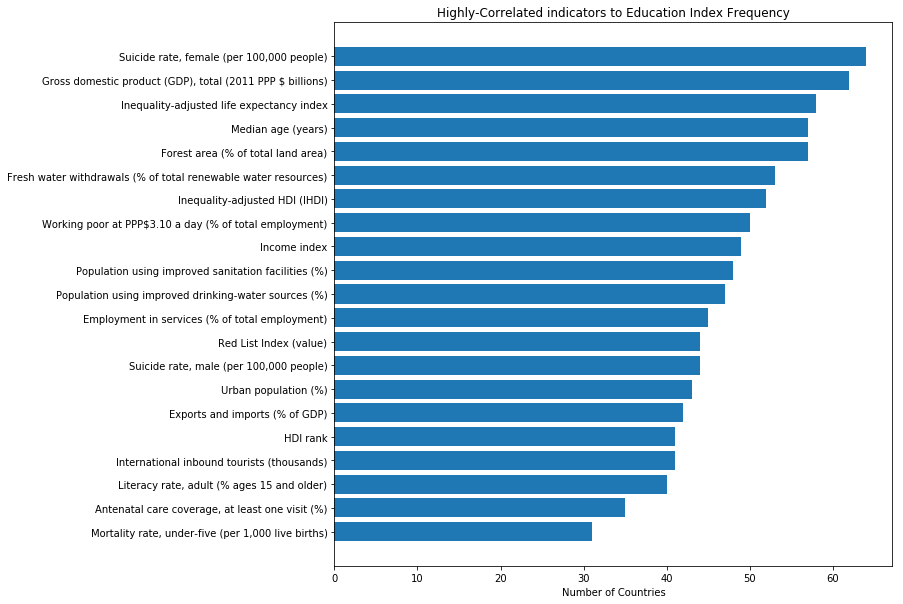

In [96]:
plot_top_indicators(sorted_top_indicators)

**Analysis of Life Expectancy and Government Spending on Education**

---

We first need to update our threshold to account for values that have single data point in each row before we begin

In [97]:
# Loading Datasets on to DataFrames
indicators_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/2018_all_indicators.csv'

inds_df = pd.read_csv(indicators_url)

inds_df = inds_df.drop(columns=['9999'])

threshold = 0
drop_stack = set()
length_before = len(inds_df)
print("Number of rows in the indicators data frame before the cleanup:", length_before)
for index, row in inds_df.iterrows():
    if row['1990':].count() <= threshold:
        drop_stack.add(index)

inds_df = inds_df.drop(drop_stack)
length_after = len(inds_df)
print("Number of rows in the indicators data frame after the cleanup:", length_after)
print("% of rows deleted: {0:.2f}%".format((length_before - length_after) * 100 / length_after))

Number of rows in the indicators data frame before the cleanup: 25636
Number of rows in the indicators data frame after the cleanup: 22918
% of rows deleted: 11.86%


**The Effects of Life Expectancy on Education**

---

 We will be exploring how the life expectancy for a country can affect the Education Index. We examined the correlations between  mean years of schooling and pisa score data indicators.

In [0]:
def plot_health(df, health_indep, target):
    health_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    #obtain rows that have the indicator matching health_indep and target respectively
    health_indicator_data = health_df[health_df.indicator_name == health_indep]
    education_index = health_df[health_df.indicator_name == target]
    #generate colors
    number = len(health_indicator_data)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, number)]
    color_index = 0
    for i in range(len(health_indicator_data)):
        health_i = []
        education_i = []
        #finds the pairs by going across each country's row
        for j in range(1990, 2018):
            c_val = health_indicator_data["country_name"].iloc[i]
            #checks if country is in both sections and then add both to respective list
            if c_val in list(education_index["country_name"]):
                health_i.append(health_indicator_data[str(j)].iloc[i])
                education_i.append(education_index[education_index.country_name == c_val][str(j)].iloc[0])
        #plots each time a country is done
        plt.scatter(health_i, education_i, color = colors[color_index], alpha = .7)
        color_index += 1
    plt.xlabel(health_indep)
    plt.ylabel(target)

*Graphing of Life Expectency vs Mean Years of Schooling*

As life expectancy increases, the mean years of schooling also appears to increase. However, the variance is quite large so it is very possible that there are other indicators that could affect the mean years of schooling.

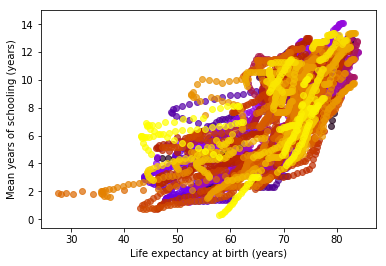

In [99]:
plot_health(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)")

In [0]:
def plot_health_by_country(df, health_indep, target, country):
    health_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    #obtain rows that have the indicator matching health_indep and target respectively
    health_indicator_data = health_df[health_df.indicator_name == health_indep]
    education_target = health_df[health_df.indicator_name == target]
    #if country not in both return
    if country not in list(education_target["country_name"]) or country not in list(health_indicator_data["country_name"]):
        print("Country value missing from a variable")
        return
    #Further limits rows to the rows with country_name equal to country
    country_health = health_indicator_data[health_indicator_data.country_name == country]
    country_education_target = education_target[education_target.country_name == country]
    health_i = []
    education_i = []
    #adds values to respective list
    for j in range(1990, 2018):
        health_i.append(country_health[str(j)].iloc[0])
        education_i.append(country_education_target[country_education_target.country_name == country][str(j)].iloc[0])
    #plots the data points for the country
    plt.scatter(health_i, education_i)
    plt.xlabel(health_indep)
    plt.ylabel(target)

Now let's have a look at Germany which had the highest educational attainment out of all the countries in 2017.

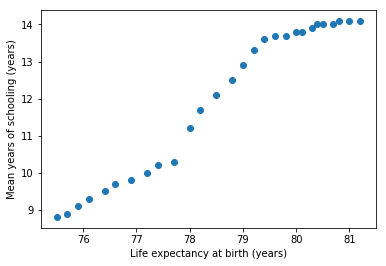

In [101]:
plot_health_by_country(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)", "Germany")

And now let's look at Japan which is known for having the highest life expectancy out of all countries today.

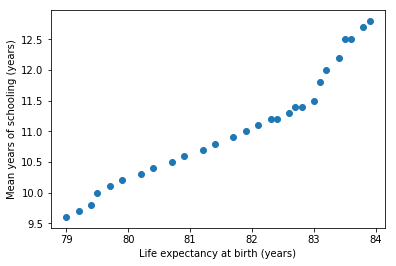

In [102]:
plot_health_by_country(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)", "Japan")

Finally, let's have a look at some countries with low educational attainment in 2017.

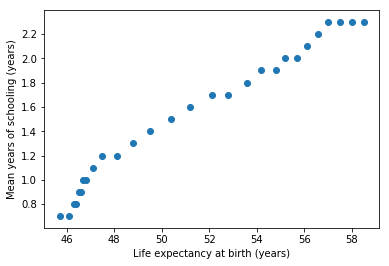

In [103]:
plot_health_by_country(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)", "Mali")

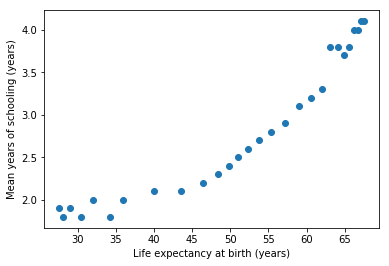

In [104]:
plot_health_by_country(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)", "Rwanda")

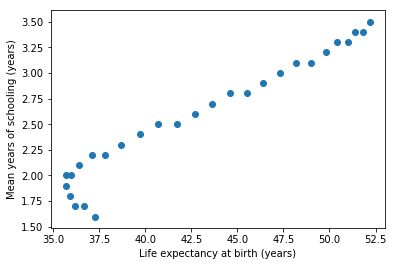

In [105]:
plot_health_by_country(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)", "Sierra Leone")

In [0]:
def plot_pisa(df, type_score):
    #Retrieves the rows where the indicator is equal to the respective values
    life_expectancy = df[df.indicator_name == "Life expectancy at birth (years)"]
    pisa = df[df.indicator_name == "Programme for International Student Assessment (PISA) score in {}".format(type_score)]
    life_val = []
    pisa_val = []
    for i in range(len(life_expectancy)):
        c_val = life_expectancy["country_name"].iloc[i]
        #checks to see if both life_expectancy and pisa have this country entry 
        if c_val in list(pisa["country_name"]):
            life_val.append(life_expectancy["2015"].iloc[i])
            #picks out the pisa entry for that country for 2015
            pisa_val.append(pisa[pisa.country_name == c_val]["2015"].iloc[0])
    plt.xlabel("Life expectancy at birth (years)")
    plt.ylabel("Programme for International Student Assessment (PISA) score in {}".format(type_score))
    plt.scatter(life_val, pisa_val)
    fit = np.polyfit(life_val, pisa_val, 1)
    fit_fn = np.poly1d(fit)
    plt.plot(life_val, fit_fn(life_val), color="red")

Plots of Life expectiancy vs 2015 Pisa scores (Change threshold to 0 before running)

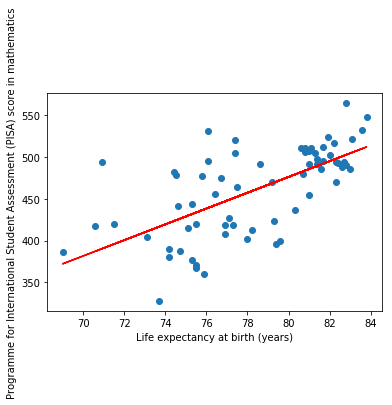

In [107]:
plot_pisa(inds_df, "mathematics")

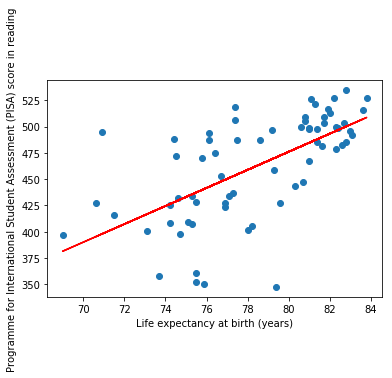

In [108]:
plot_pisa(inds_df, "reading")

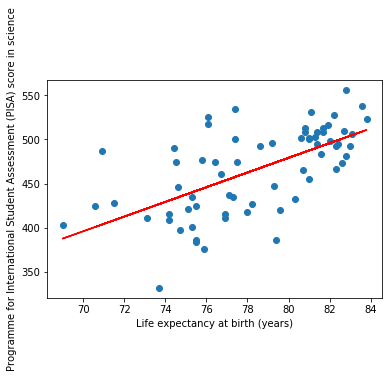

In [109]:
plot_pisa(inds_df, "science")

In [110]:
plot_country_life_vs_edu(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)", "Rwanda")

NameError: ignored

In [0]:
plot_country_life_vs_edu(inds_df, "Life expectancy at birth (years)", "Mean years of schooling (years)", "Sierra Leone")

Creates a bar graph for the countries with the highest education indexes for each year. In addition to this future prediction graphs are created using the Education Index Model.

In [0]:
def plot_education_index(df):
    new_df = df.drop(df.columns[[0, 1, 3]], axis=1)
    new_df = new_df[new_df.indicator_name == "Education index"]
    countries = []
    for i in range(0, len(new_df)):
        countries.append(new_df["country_name"].iloc[i])
    #y_pos = np.arange(len(countries))
    #year_education_inds = []
    for year in range(1990, 2018):
        education_ind = []
        for i in range(0, len(new_df)):
            if str(new_df[str(year)].iloc[i]) == "nan":
                education_ind.append(0)
            else:
                education_ind.append(float(new_df[str(year)].iloc[i]))      
        #year_education_inds.append(education_ind)
        edu_idx_list = [[countries[j], education_ind[j]] for j in range(len(countries))]
        edu_idx_list.sort(key=lambda x: x[1])
        #print(edu_idx_list)
        top_x_vals = []
        top_y_vals = []
        indicator_num = 20
        for j in range(indicator_num):
            top_x_vals.append(edu_idx_list[len(edu_idx_list) - indicator_num + j][0])
            top_y_vals.append(edu_idx_list[len(edu_idx_list) - indicator_num + j][1])
        y_pos = np.arange(len(top_x_vals))
        plt.figure(figsize=(10,10))
        plt.barh(y_pos, top_y_vals, align='center', alpha=0.5)
        plt.yticks(y_pos, top_x_vals)
        plt.xlabel('Education index')
        plt.title("Countries with Highest Educational Attainment in {}".format(year))
    prediction_plot(countries, 2018, 2025)

In [0]:
def prediction_plot(countries, year_start, year_end):
    y_pos = np.arange(len(countries))
    y_val_dict = {}
    for i in range(year_start, year_end + 1):
        y_val_dict[i] = []
    #for country in countries:
    country_amt = 0
    for country in country_indicators:
        eim.fit(inds_df, country, country_indicators[country])
        ret_val = eim.predict_year([year for year in range(year_start, year_end + 1)])
        for year in range(year_start, year_end + 1):
            y_val_dict[year].append(ret_val[year - year_start])
        country_amt += 1
    for year in range(year_start, year_end + 1):
        #edu_idx_list = [[countries[j], y_val_dict[year][j]] for j in range(len(countries))]
        edu_idx_list = [[countries[j], y_val_dict[year][j]] for j in range(country_amt)]
        edu_idx_list.sort(key=lambda x: x[1])
        top_x_vals = []
        top_y_vals = []
        indicator_num = 20
        for j in range(indicator_num):
            top_x_vals.append(edu_idx_list[len(edu_idx_list) - indicator_num + j][0])
            top_y_vals.append(edu_idx_list[len(edu_idx_list) - indicator_num + j][1])
        y_pos = np.arange(len(top_x_vals))
        plt.figure(figsize=(10,10))
        plt.barh(y_pos, top_y_vals, align='center', alpha=0.5)
        plt.yticks(y_pos, top_x_vals)
        plt.xlabel('Education index')
        plt.title("Countries with Highest Educational Attainment in {}".format(year))

In [0]:
plot_education_index(inds_df)

**The Effect of Government Spending on Education**\

---


We will be exploring the effects of government spending while looking at education index and PISA scores. 

The following cell will return a 2D list containing the x and y values of the specified indicators xkey and ykey. It will contain values for all countries that have a value for both indicators, in this case in the year 2015.

In [0]:
def get_xy_lists(xkey, ykey, inds_df):
  comparematrix = [[],[]]
  print(comparematrix)
  for i in country_names :
    df_corr = plot_corr_country(inds_df, i)
    if xkey in df_corr :
      for yearnum in range(2015, 2016):
        year = str(yearnum)
        try :
          xvalue = float(df_corr[xkey].loc[year])
          if not np.isnan(xvalue):
            comparematrix[0].append(xvalue)
            comparematrix[1].append(float(df_corr[ykey].loc[year]))
            break
        except KeyError as e :
          if len(comparematrix[0]) > len(comparematrix[1]) :
            comparematrix[0].pop()
          elif len(comparematrix[1]) > len(comparematrix[0]) :
            comparematrix[1].pop()
          break
  return comparematrix

country_names = inds_df.country_name.unique()

Call the function to with specified indicators and then create a scatter plot

In [0]:
xkey = 'Government expenditure on education (% of GDP)'
ykey = 'Mean years of schooling (years)'
comparematrix = get_xy_lists(xkey, ykey, inds_df)
plt.scatter(comparematrix[0], comparematrix[1])
plt.xlabel(xkey)
plt.ylabel(ykey)

In [0]:
ykey = 'Programme for International Student Assessment (PISA) score in mathematics'
xkey = 'Mean years of schooling (years)'
comparematrix = get_xy_lists(xkey, ykey, inds_df)
plt.scatter(comparematrix[0], comparematrix[1])
plt.xlabel(xkey)
plt.ylabel(ykey)

In [0]:
xkey = 'GDP per capita (2011 PPP $)'
ykey = 'Mean years of schooling (years)'
comparematrix = get_xy_lists(xkey, ykey, inds_df)
plt.scatter(comparematrix[0], comparematrix[1])
plt.xlabel(xkey)
plt.ylabel(ykey)

The following function is based on the previous one but one of the indicators is now set. This is because this function will be calculating the amount of GDP per capita that is spent on education and will need to multiply two indicators in order to do so. When we call this function, we sort the x and y pairs by their x, in order to identify and remove our outlier. We then scatter plot these values and draw 2 lines, the first line will be the best fit up to the number of points specified by boundary. The second line will be the best fit of the rest. We can remove this sorting and pop and it will work fine, but the best fit line of the second half will be heavily skewed by it.

In [0]:
def get_xy_gdp(ykey, inds_df):
  xkey1 = 'GDP per capita (2011 PPP $)'
  xkey2 = 'Government expenditure on education (% of GDP)'
  xkey3 = 'Total population (millions)'
  comparematrix = [[],[]]
  print(comparematrix)
  for i in country_names :
    df_corr = plot_corr_country(inds_df, i)
    if xkey in df_corr :
      for yearnum in range(2013, 2016):
        year = str(yearnum)
        try :
          gdppercap = float(df_corr[xkey1].loc[year]) * float(df_corr[xkey2].loc[year])/100
          if not np.isnan(gdppercap):
            comparematrix[0].append(gdppercap)
            comparematrix[1].append(float(df_corr[ykey].loc['2015']))
            break
        except KeyError as e :
          if len(comparematrix[0]) > len(comparematrix[1]) :
            comparematrix[0].pop()
          elif len(comparematrix[1]) > len(comparematrix[0]) :
            comparematrix[1].pop()
          break
  return comparematrix

ykey = 'Programme for International Student Assessment (PISA) score in mathematics'
comparematrix = get_xy_gdp(ykey, inds_df)

plt.xlabel('GDP per capita spent on education ')
plt.ylabel(ykey)

pairs = sorted(list(zip(comparematrix[0], comparematrix[1])), key=lambda x: x[0])
comparematrix[0], comparematrix[1] = zip(*pairs)
comparematrix[0] =list(comparematrix[0])
comparematrix[1] =list(comparematrix[1])
comparematrix[0].pop()
comparematrix[1].pop()
plt.scatter(comparematrix[0], comparematrix[1])
boundary = 32
plt.plot(np.unique(comparematrix[0][0:boundary]), np.poly1d(np.polyfit(comparematrix[0][0:boundary], comparematrix[1][0:boundary], 1))(np.unique(comparematrix[0][0:boundary])))
plt.plot(np.unique(comparematrix[0][boundary:]), np.poly1d(np.polyfit(comparematrix[0][boundary:], comparematrix[1][boundary:], 1))(np.unique(comparematrix[0][boundary:])))